In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import holidays

In [29]:
sns.set_theme()

In [6]:
df = pd.read_parquet('../data_export/prueba_ml.parquet')
df.reset_index(inplace=True, drop=True)
df['dia_semana'] = df['fecha'].dt.weekday + 1
year = 2023
us_holidays = holidays.US(years=year)
us_holidays
df['holiday'] = np.where(df['fecha'].isin(us_holidays), 1, 0)
df['rain'] = df['rain'].shift(1)
df['snowfall'] = df['snowfall'].shift(1)
df.fillna(0.0, inplace=True)
df['datetime'] = pd.to_datetime(df['fecha'].astype(str) + ' ' + df['hora'].astype(int).astype(str) + ':00:00')
df.drop(columns='fecha', inplace=True)
df.set_index('datetime', inplace=True)
df.head()

,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island,año,mes,dia,dia_semana,holiday
datetime,,,,,,,,,,,,,,,
2023-11-01 00:00:00,0.0,8.6725,0.0,60.153034,0.0,3,12,2196,232,1,2023,11,1,3,0
2023-11-01 01:00:00,1.0,8.5725,0.1,60.344471,0.0,2,12,1521,55,0,2023,11,1,3,0
2023-11-01 02:00:00,2.0,8.3225,0.0,62.933163,0.0,3,8,1214,16,0,2023,11,1,3,0
2023-11-01 03:00:00,3.0,8.0725,0.1,66.100021,0.0,0,13,854,20,0,2023,11,1,3,0
2023-11-01 04:00:00,4.0,7.7725,0.0,72.938622,0.0,12,20,654,25,0,2023,11,1,3,0


In [11]:
columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
X = df[columnas_X]

columnas_Y= ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
Y = df[columnas_Y]

Probemos inicialmente con Manhattan:

RMSE:  1161.3825817245176


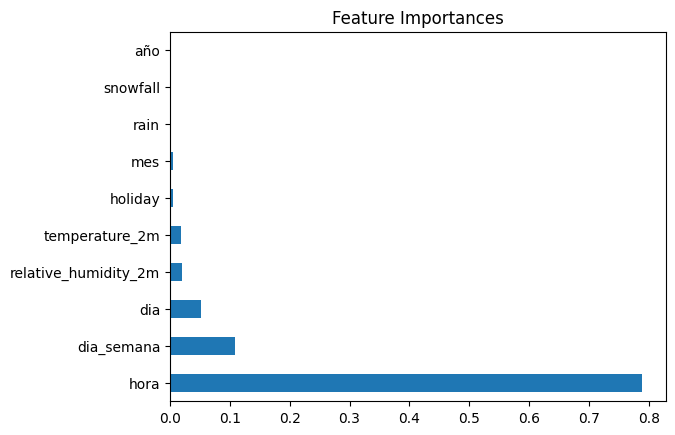

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['Manhattan'], test_size=0.2, random_state=42, shuffle=False)

# Crear y entrenar el modelo RandomForest
model = RandomForestRegressor(n_estimators=100, random_state=42)  # Puedes ajustar más hiperparámetros según sea necesario
model.fit(X_train, y_train)

# Predecir los datos de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("RMSE: ", rmse)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.show()

Grafiquemos las predicciones y los valores reales:

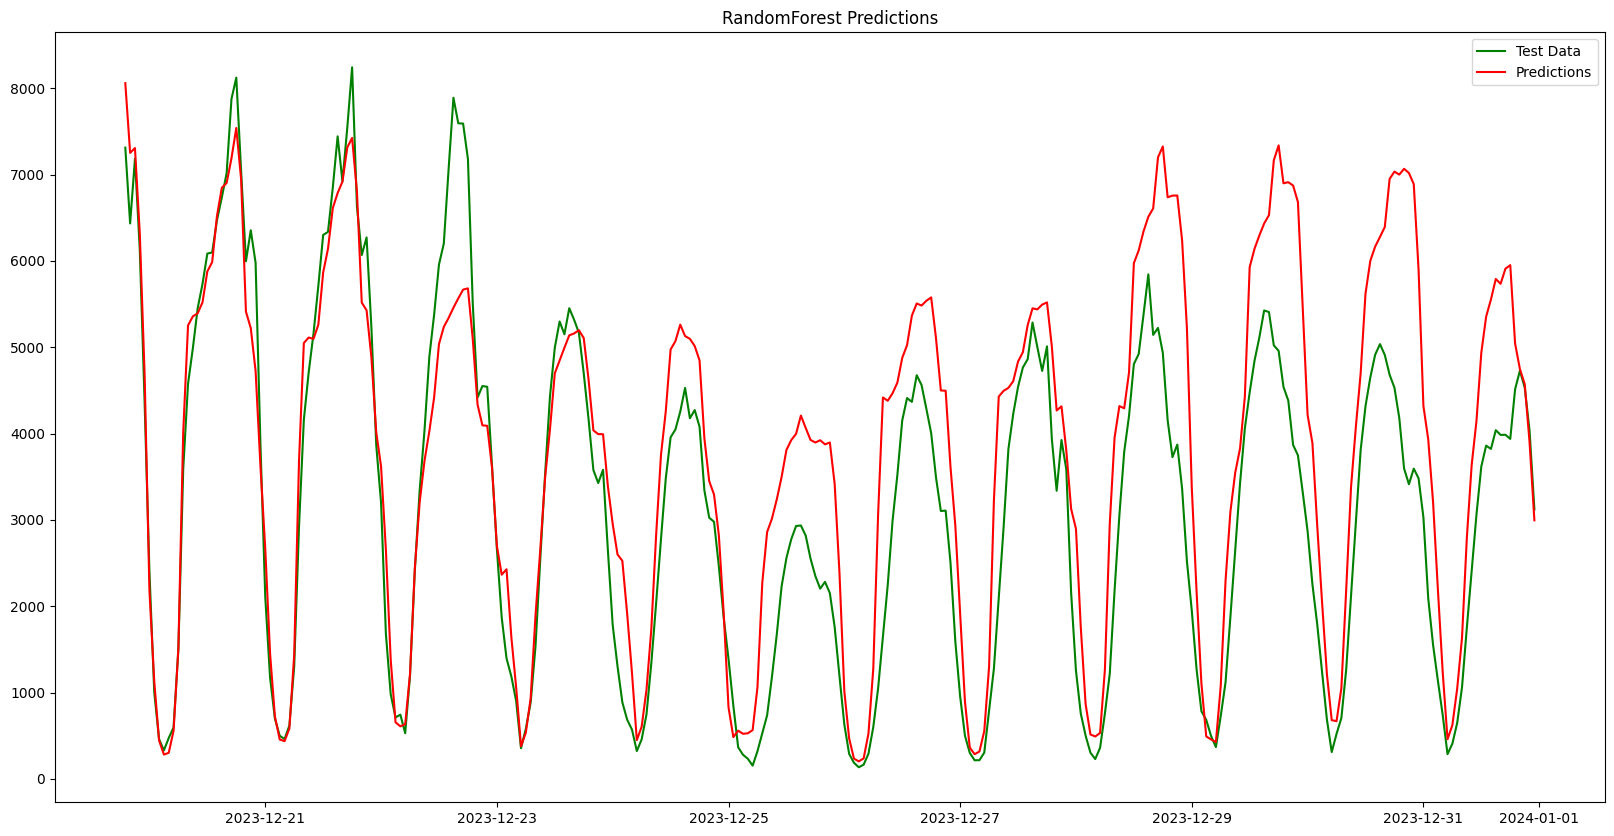

In [19]:
y_pred = pd.Series(data=y_pred, index=y_test.index)
plt.figure(figsize=(20, 10))
plt.plot(y_test, label='Test Data', color='green')
plt.plot(y_pred, label='Predictions', color='red')
plt.title('RandomForest Predictions')
plt.legend()
plt.show()

Vemos que Random Forest realiza una predicción excelente de la demanda. Generemos ahora una función que devuelva modelos de Random Forest entrenados para cada distrito.

In [20]:
def generar_modelos(df):

    columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
    X = df[columnas_X]

    columnas_Y= ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
    Y = df[columnas_Y]

    models = {}
    predictions = {}
    errors = {}

    for district in columnas_Y:
        print('Inicio de evaluación de', district)
        X_train, X_test, y_train, y_test = train_test_split(X, Y[district], test_size=0.2, random_state=42, shuffle=False)

        # Crear y entrenar el modelo RandomForest
        model = RandomForestRegressor(n_estimators=100, random_state=42) 
        model.fit(X_train, y_train)
        models[district] = model
        # Predecir los datos de prueba
        y_pred = model.predict(X_test)

        # Evaluar el modelo
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        errors[district] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

        print('RMSE:', rmse)

        predictions_df = pd.DataFrame({
        'Predicted': y_pred,
        'Real values': y_test
        }, index=y_test.index )

        predictions[district] = predictions_df
        
        print('-----------------------------------------------------------------------------------------')
    return models, predictions, errors


In [26]:
def graficar_predicciones(predictions):
    for district, data in predictions.items():
        plt.figure(figsize=(20, 10))
        plt.plot(data['Real values'], label='Test Data', color='green')
        plt.plot(data['Predicted'], label='Predictions', color='red')
        plt.legend()
        plt.title(f'RandomForest Predictions for {district}')
        plt.xlabel('Date')
        plt.ylabel('Demand')
        plt.show()

In [42]:
def graficar_importancias(models, features= ['año', 'mes', 'dia', 'hora', 'dia_semana', 
                                             'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']):
    
    for district, model in models.items():
        feature_importances = pd.Series(model.feature_importances_, index=features)
        plt.figure(figsize=(5, 5))
        feature_importances.nlargest(10).plot(kind='barh')
        plt.title(f'Feature Importances in {district}')
        plt.show()

In [24]:
models, predictions, errors = generar_modelos(df)

Inicio de evaluación de Bronx
RMSE: 6.467259153275937
-----------------------------------------------------------------------------------------
Inicio de evaluación de Brooklyn
RMSE: 24.46157901941056
-----------------------------------------------------------------------------------------
Inicio de evaluación de Manhattan
RMSE: 1161.3825817245176
-----------------------------------------------------------------------------------------
Inicio de evaluación de Queens
RMSE: 153.67934954681812
-----------------------------------------------------------------------------------------
Inicio de evaluación de Staten Island
RMSE: 0.3663168773173146
-----------------------------------------------------------------------------------------


El entrenamiento de los predictores de los 5 distritos duró 5.4 segundos.

Grafiquemos las predicciones:

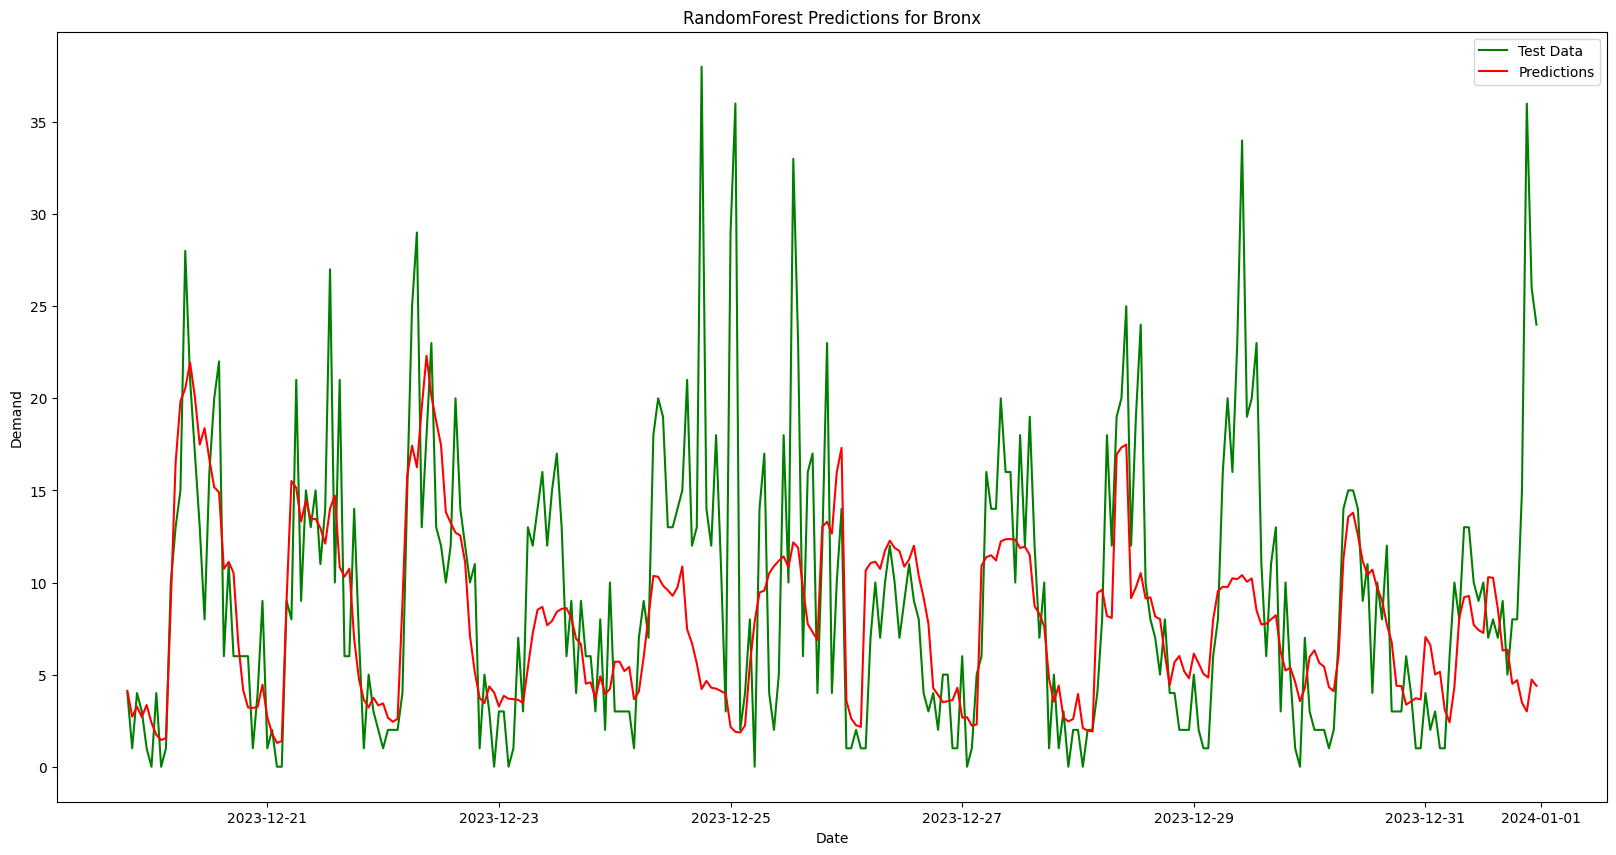

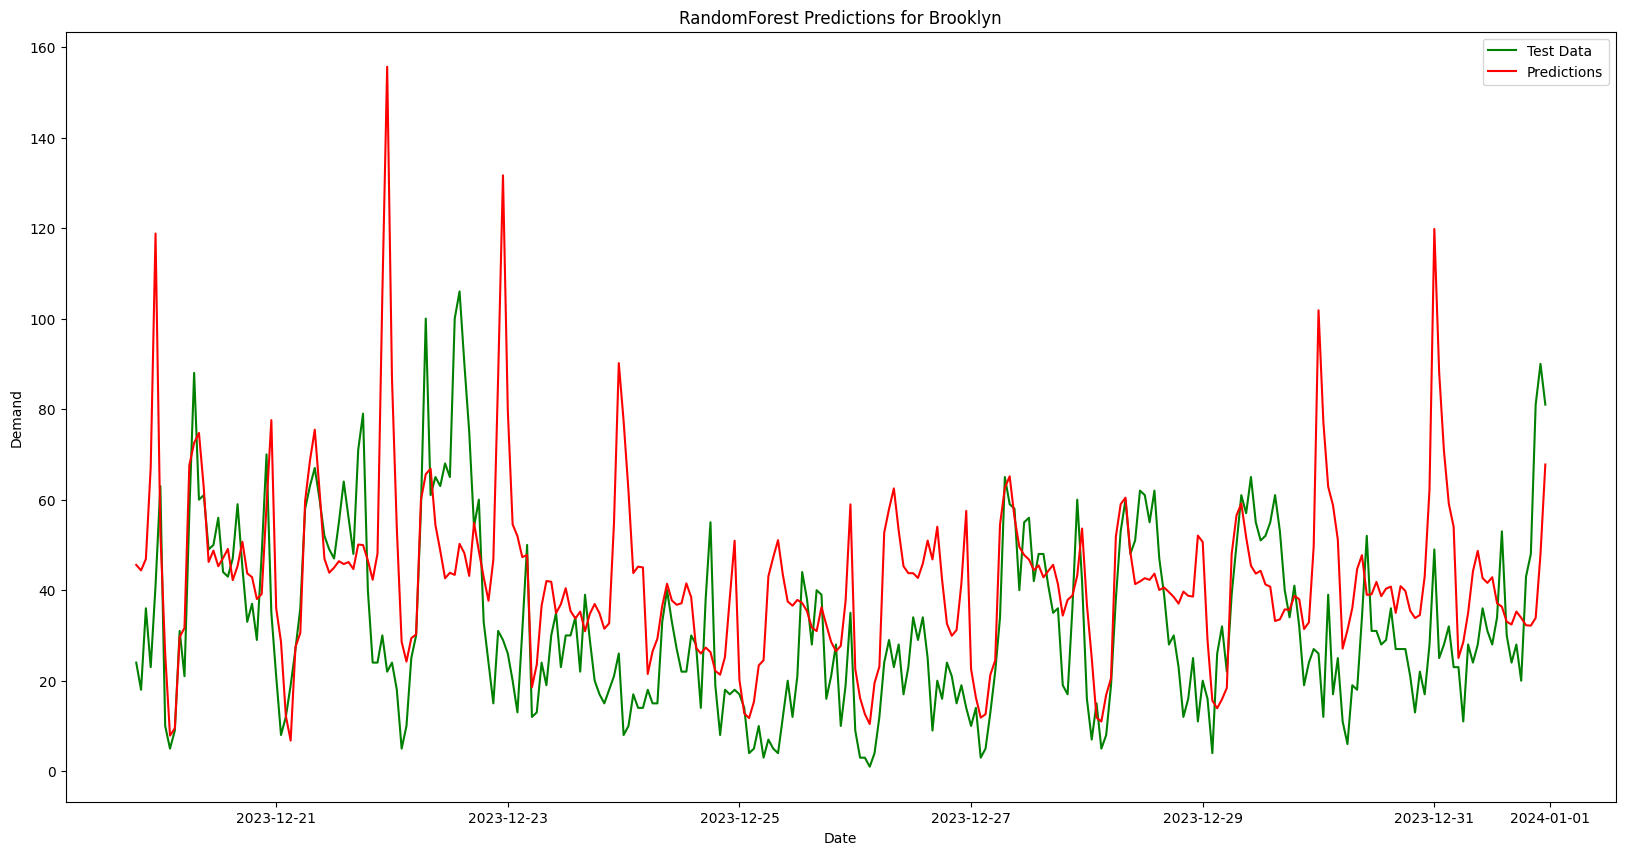

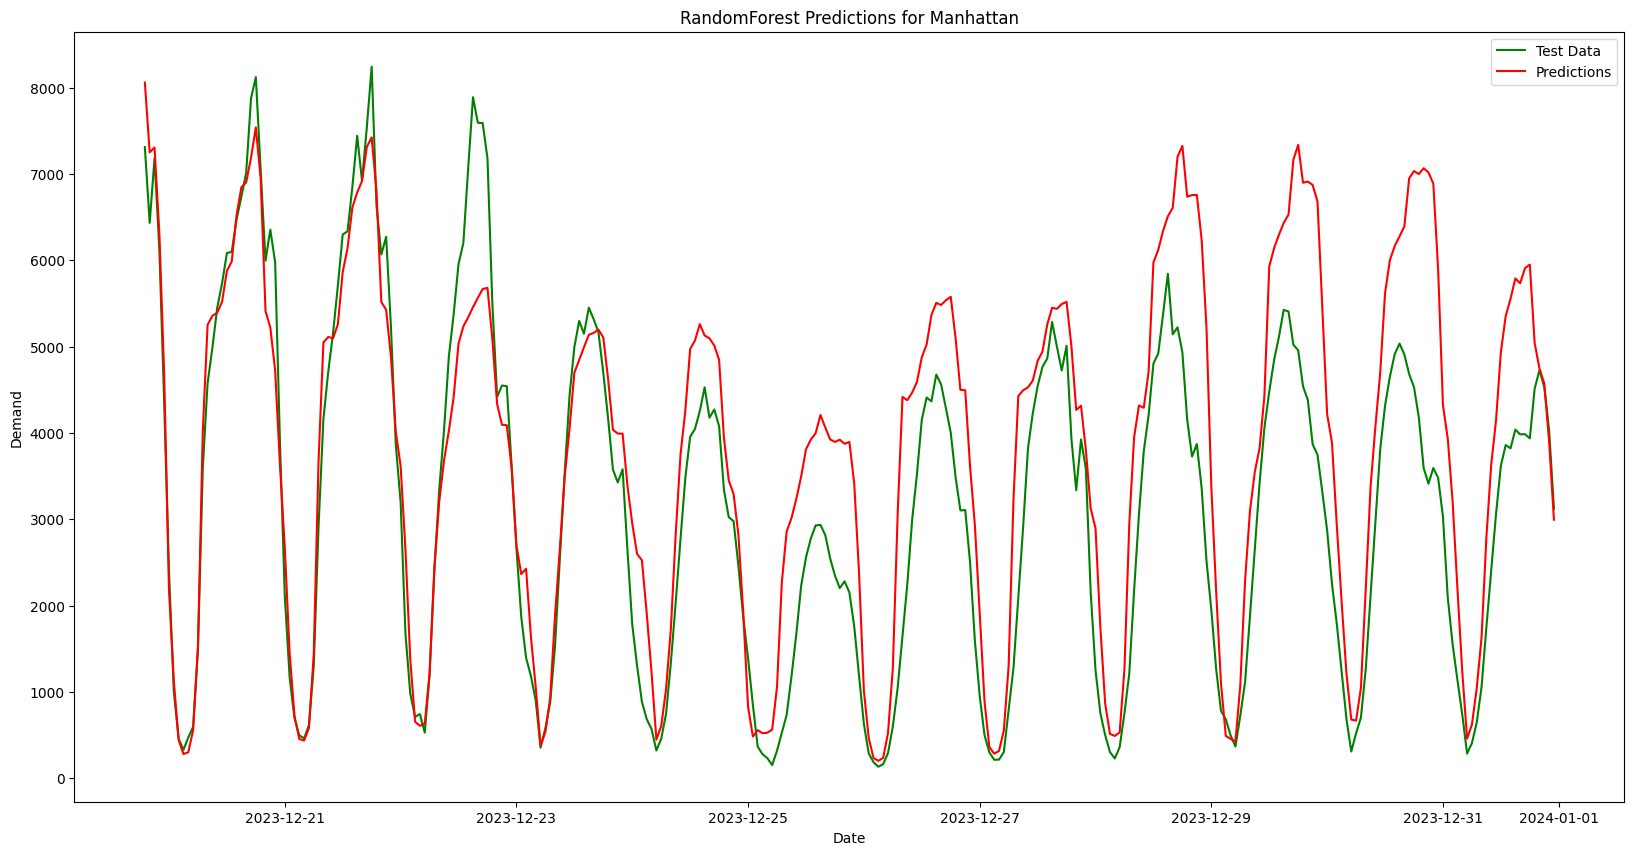

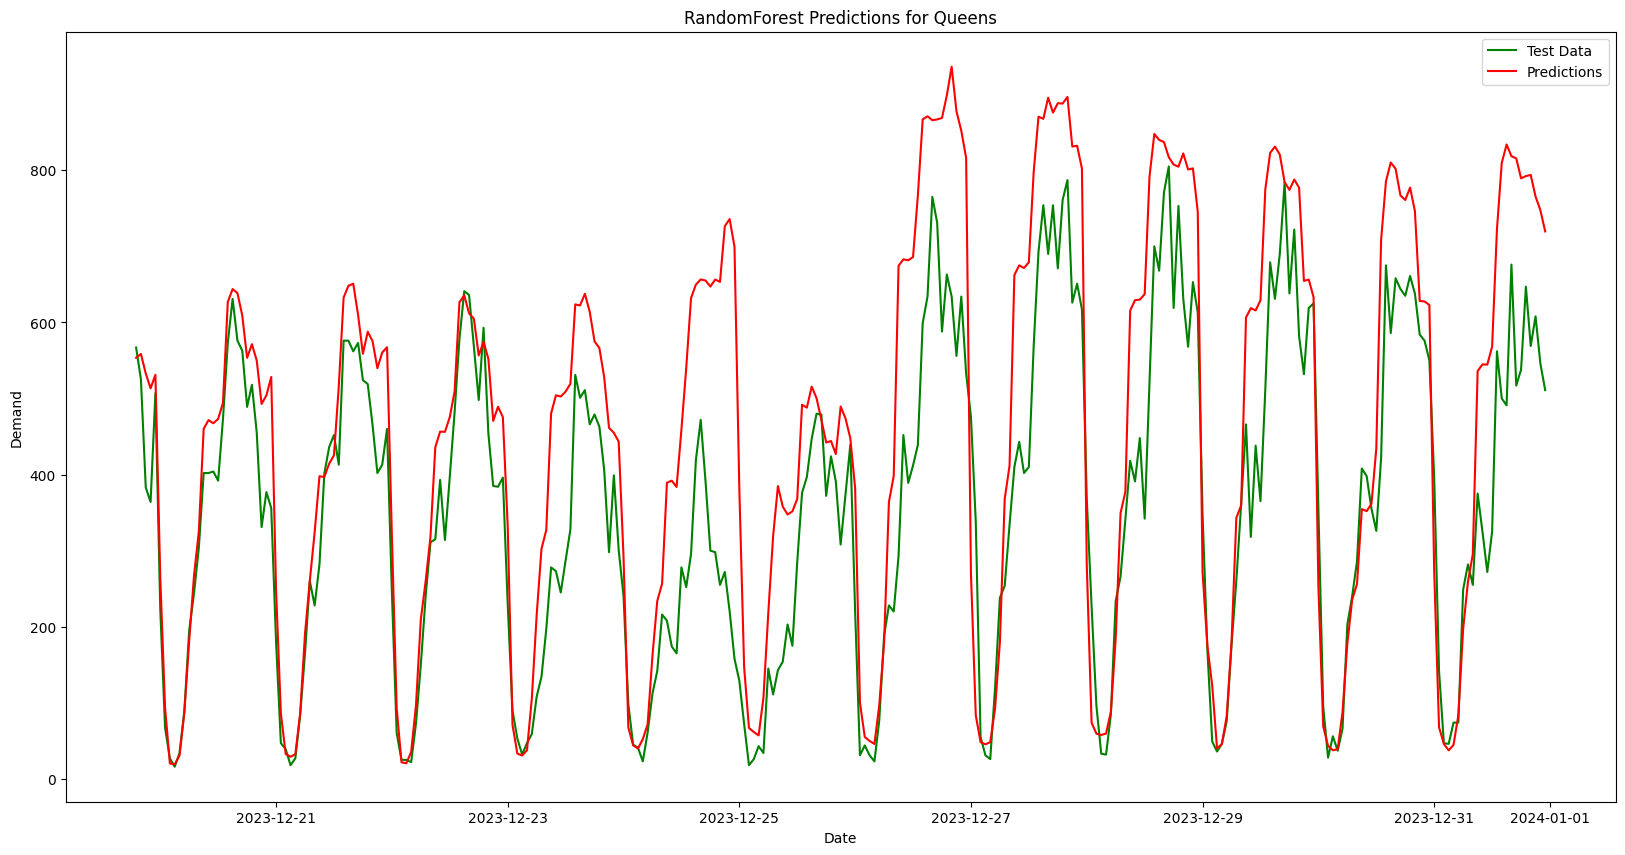

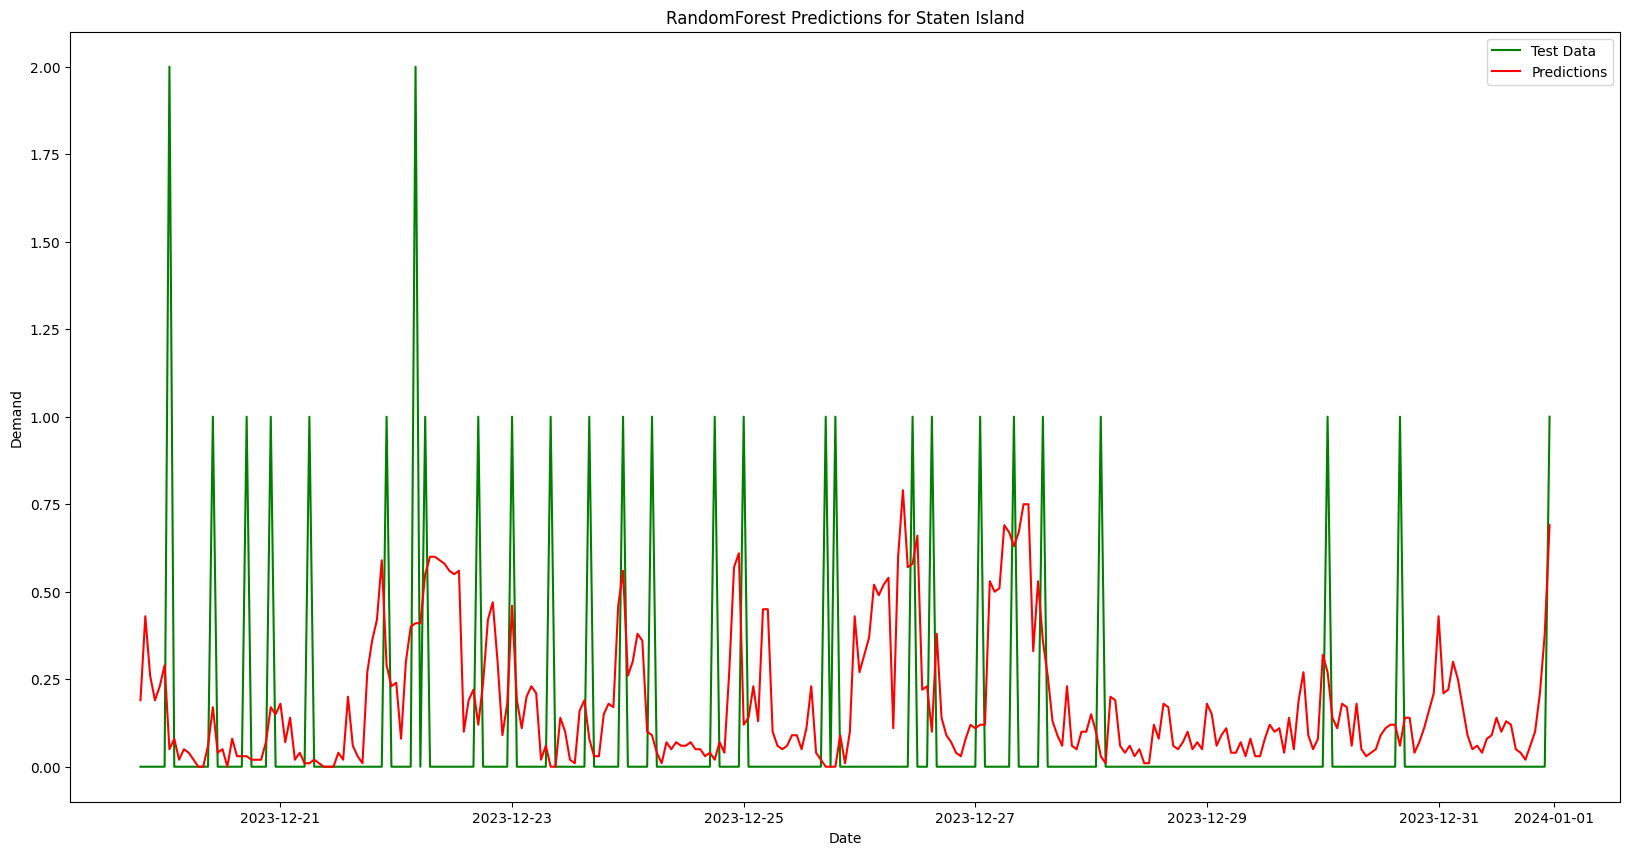

In [27]:
graficar_predicciones(predictions)

Veamos los errores:

In [28]:
errors

{'Bronx': {'MAE': 4.282252559726961,
  'MSE': 41.82544095563139,
  'RMSE': 6.467259153275937,
  'MAPE': inf},
 'Brooklyn': {'MAE': 17.329590443686005,
  'MSE': 598.3688481228669,
  'RMSE': 24.46157901941056,
  'MAPE': 98.05521864258137},
 'Manhattan': {'MAE': 870.8689419795221,
  'MSE': 1348809.501133106,
  'RMSE': 1161.3825817245176,
  'MAPE': 41.68815139214171},
 'Queens': {'MAE': 115.19549488054606,
  'MSE': 23617.342477133105,
  'RMSE': 153.67934954681812,
  'MAPE': 41.76245169777306},
 'Staten Island': {'MAE': 0.23709897610921501,
  'MSE': 0.13418805460750852,
  'RMSE': 0.3663168773173146,
  'MAPE': inf}}

Veamos la importancia de las variables:

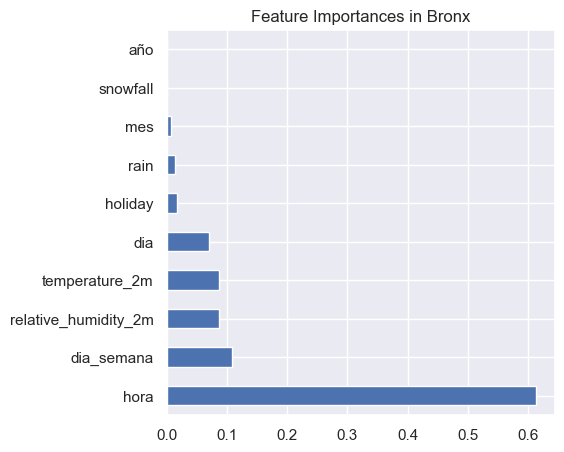

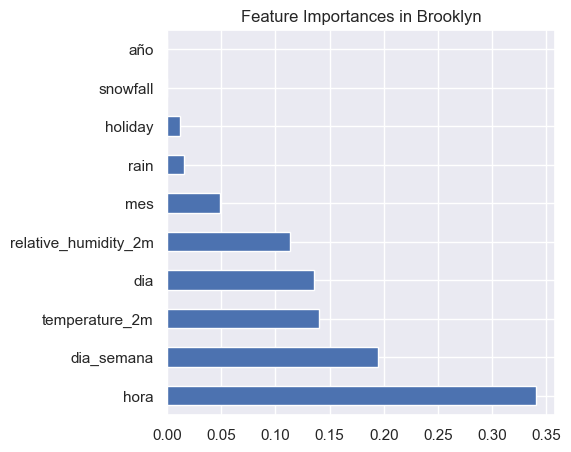

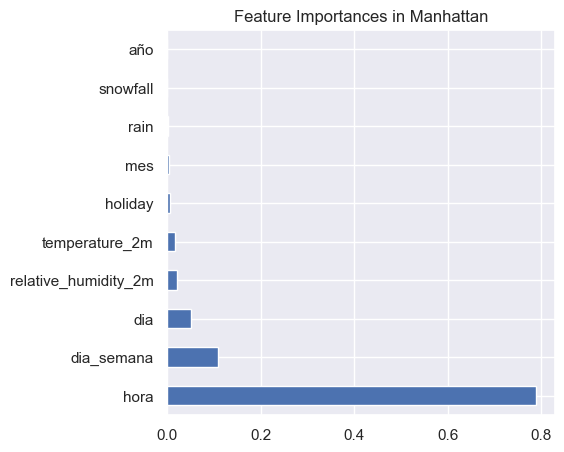

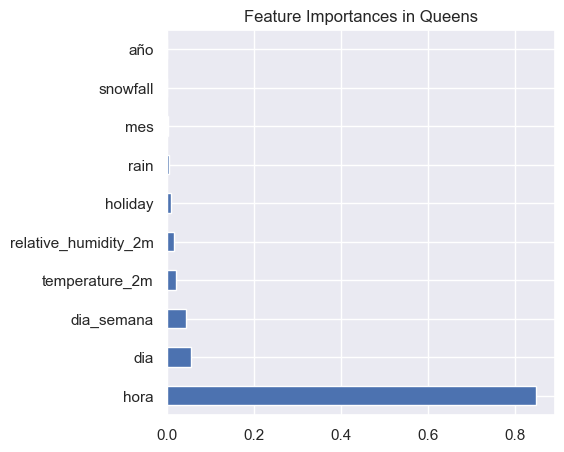

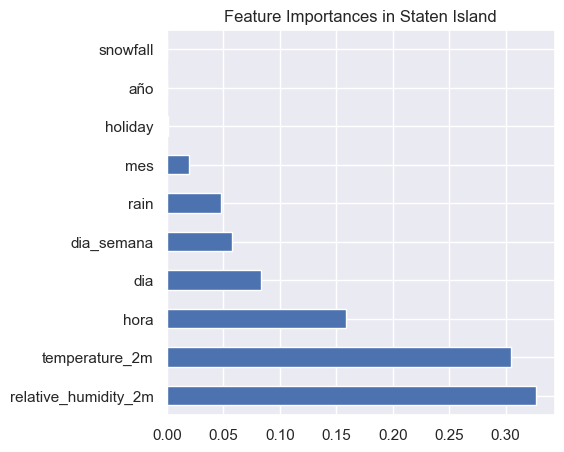

In [41]:
graficar_importancias(models)